In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve

assume normal distribution

96.56–104.97% (90% CI) AUC

81.68–95.13% (90% CI) geometric mean cipro/androcur

mean androcur=175ng/mL

mean ciproterone=150ng/mL

80-125% (90% CI) Cmax 

Cmax androcur calculations: 

ratio mu=0.88405,sigma=0.04088551

geom mean cipro,androcur: 162.019

In [261]:
def exp_cpa_decay(conc):
    if conc>100:
        return conc*0.5**(1/np.random.normal(loc=8,scale=1))
    elif conc>50:
        return conc*0.5**(1/np.random.normal(loc=32,scale=3))
    elif conc>20:
        return conc*0.5**(1/np.random.normal(loc=60,scale=12))
    else:
        return conc*0.8**(1/np.random.normal(loc=96,scale=24))

0.38728561559937763 0.9063306958052078


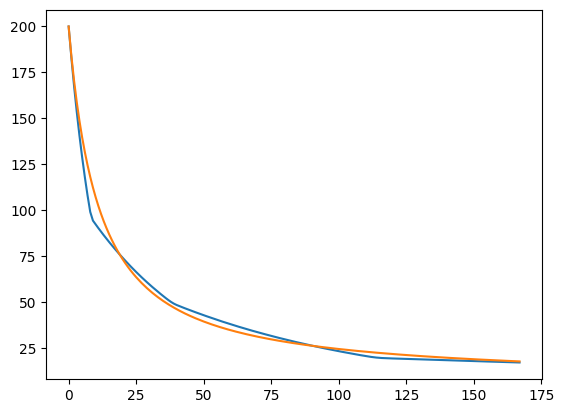

0.3654060302531608 0.9179333313734223


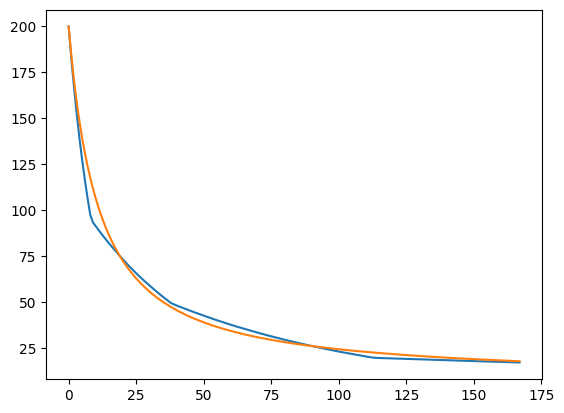

0.4145614233297459 0.8927328666840082


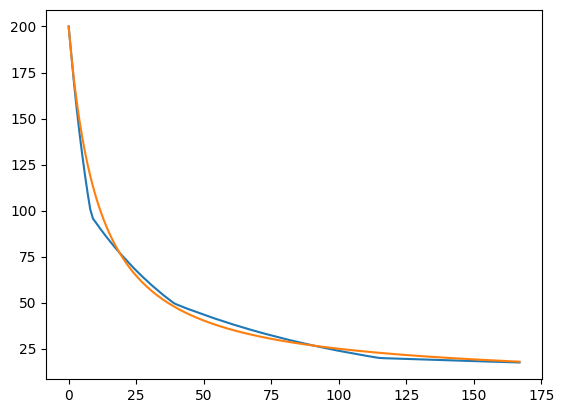

In [262]:
#checking cpa_decay
def testfunc(x,a,b):
    return 200*0.5**(x/(a*x**b+8))
    
lm=[]
for i in range(1000):
    l=[200]
    for j in range(167):
        l.append(exp_cpa_decay(l[-1]))
    lm.append(l.copy())
lmm=np.mean(np.array(lm),axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lmm)
plt.plot(np.arange(168),lmm)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm32=np.percentile(np.array(lm),32,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm32)
plt.plot(np.arange(168),lm32)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm68=np.percentile(np.array(lm),68,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm68)
plt.plot(np.arange(168),lm68)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

In [263]:
#fit function of d[cpa]/dt against [cpa]
def function(x,xx):
    a=0.386+0.0272*xx #fitted from piecewise function of exponentials, estimated std
    b=0.907-0.0141*xx
    return 200*0.5**(x/(a*x**b+8))

xs=np.arange(1,200,1)
xxs=np.arange(-2,2.01,0.01)

res=np.zeros((xs.shape[0],xxs.shape[0]))

for j,xx_value in enumerate(xxs):
    def diff(x,a):
        return (function(x,xx_value)-a)**2
    for i,x_value in enumerate(xs):
        res[i,j]=fsolve(diff, np.array(1.0), args=(x_value), xtol=1e-11, maxfev=2000)
np.save('inverseLUT.npy',res)

C:\Users\reiner\AppData\Local\Temp\ipykernel_21124\1482477068.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[i,j]=fsolve(diff, np.array(1.0), args=(x_value), xtol=1e-11, maxfev=2000)
c:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

In [ ]:
res=np.load('inverseLUT.npy')

In [ ]:
res[100-1,200] #checking against https://www.desmos.com/calculator/roq7rjmjkp

11.551369578692753

In [ ]:
def cpa_decay(conc):
    xx=np.clip(np.random.normal(),-1,1)
    ctime=np.interp([conc],np.arange(1,200,1),res[:,np.round(xx*100).astype(int)+200])[0]
    return function(ctime+1,xx)

In [ ]:
def cpa_metabolite(cpa_arr):
    r = [0]
    for i in range(1,len(cpa_arr)):
        delta_cpa=max(cpa_arr[i-1]-cpa_arr[i],0)
        const = math.log(.5)/24/3
        def drdt(cpa_m):
            #t is in [0,1]
            return cpa_m*const+delta_cpa
        r1=drdt(r[-1]) #RK4
        r2=drdt(r[-1]+r1*0.5)
        r3=drdt(r[-1]+r2*0.5)
        r4=drdt(r[-1]+r3)
        r.append(r[-1]+(r1+r2*2+r3*2+r4)/6)
    return r

conservative estimate of unsafe dosage: 25mg/day

min,max,mean: (37.26690717169299, 107.7282828387695, 72.4945087102889)

comparison for side effects: intolerable for first 12h at 37.5mg

56.44ng/ml (97.5% confident that intolerable conc. was at least this)

In [ ]:
def simulate(dose,intervals,plot=True):
    repeat=sum(intervals)
    for i in range(len(intervals)-1,0,-1):
        intervals[i]=sum(intervals[:i+1])
    l=[dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5]
    for i in range(repeat*5):
        l.append(cpa_decay(l[-1]))
        if (i%repeat)+1 in intervals:
            l[-1]+=dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5
    if plot:
        plt.plot(np.arange(repeat*5+1)/24,l,'r',alpha=0.01)
    
    return [min(l),max(l),np.mean(l)],l

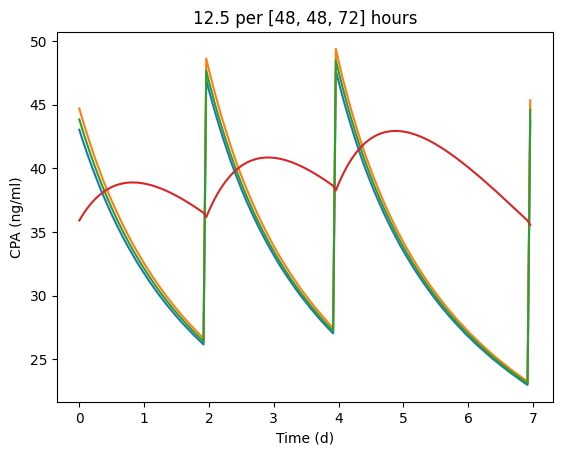

16.59558031476663 50.20762162333166 32.21172589941655


In [ ]:
def check(dose,intervals,steady=False):
    r=sum(intervals)
    checker=[]
    for i in range(100):
        m,l=simulate(dose,intervals.copy(),plot=(not steady))
        checker.append(l)
    if steady:
        plt.plot(np.arange(r)/24,np.percentile(checker,5,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.percentile(checker,95,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.mean(checker,axis=0)[-r:])
        plt.plot(np.arange(r)/24,cpa_metabolite(np.mean(checker,axis=0))[-r:])
    plt.xlabel('Time (d)')
    plt.ylabel('CPA (ng/ml)')
    plt.title(str(dose)+' per '+str(intervals)+' hours')
    plt.show()
    print(np.min(checker),np.max(checker),np.mean(checker))
check(12.5,[48,48,72],steady=True)

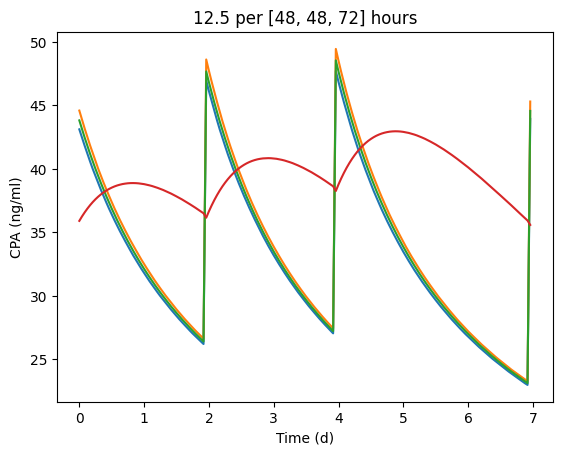

16.54312388549552 50.53742439609199 32.21071208715566


In [ ]:
#25 every 3-4 days, side effects ;-;
#check(25,[72,96],steady=True)

#25/week, too variable
#check(25,[7*24],steady=True)

#12.5/3-4 days?
#check(12.5,[72,96],steady=True)

#12.5/2-3 days (current)
check(12.5,[48,48,72],steady=True)

14.1


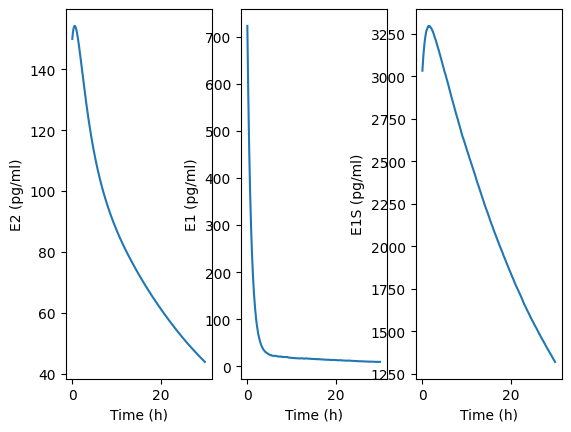

In [3]:
# e2, e1, e1 sulfate
e = [np.array([150,723,3033])] #150pg/ml peak for single dose 2mg
dt=.03
def est_rk4(e, dt):
    # conversion 15%, 65% e2, 5%, 54% e1, 1.4%, 21% e1 sulfate
    # clearance 20% e2, 41% e1, 77.6% e1 sulfate
    ma, mb, mc = 272.4, 270.366, 350.429
    randc3 = np.random.beta(2,5)
    c1,c3=7.52e-2, 1e-2**randc3*4e-2**(1-randc3)
    c12, c13 = c1/2*1.5, c1/2*6.5
    c32=c3/77.6*21
    c32b=c32/mc*mb
    c31=c13*4.5e-2/ma*mc#c3/77.6*1.4
    c21a=c12
    c21=c21a/ma*mb
    c23, c2 = c21/5*54, c21/5*41
    c12b,c13c,c23c,c31a = c12/ma*mb, c13/ma*mc, c23/mb*mc, c31/mc*ma
    def deltaest(e):
        return np.array([[-c1-c12-c13,c21a,c31a],[c12b,-c2-c21-c23,c32b],[c13c,c23c,-c3-c31-c32]])@e
    v1 = deltaest(e)
    v2 = deltaest(e+dt/2*v1)
    v3 = deltaest(e+dt/2*v2)
    v4 = deltaest(e+dt*v3)
    return e+dt*(v1+2*(v2+v3)+v4)/6

for i in range(1000):
    new = est_rk4(e[-1], dt)
    if (new[0]-75)*(e[-1][0]-75)<0:
        print(i*dt)
    e.append(new)
f,ax=plt.subplots(1,3)
e=np.array(e).T
t=np.arange(1001)*dt
ax[0].plot(t,e[0]);ax[1].plot(t,e[1]);ax[2].plot(t,e[2])
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel('E2 (pg/ml)')
ax[1].set_xlabel('Time (h)')
ax[1].set_ylabel('E1 (pg/ml)')
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('E1S (pg/ml)')
plt.show()


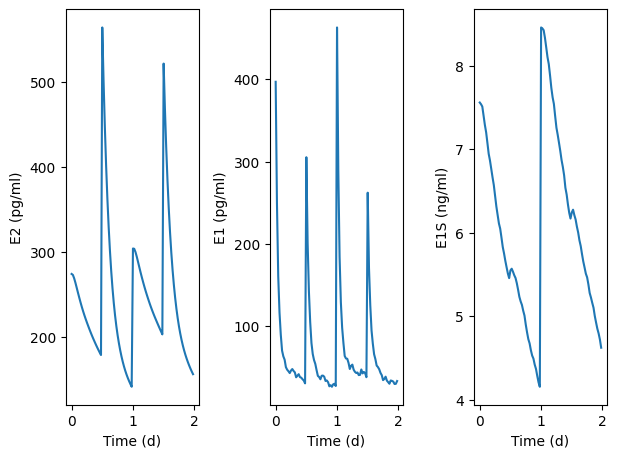

array([274.42774812, 273.32297642, 269.33514862, 264.03724029,
       258.21177962, 252.30520273, 246.54630349, 240.9917647 ,
       235.69123901, 230.70004683, 225.99939187, 221.56536275,
       217.35203144, 213.27869645, 209.31531637, 205.47259965,
       201.77693061, 198.24576421, 194.8189703 , 191.47960084,
       188.24823011, 185.12116272, 182.1051234 , 179.21320631,
       563.8847391 , 501.47821427, 447.69492199, 401.73099075,
       362.6663628 , 329.57211628, 301.5387375 , 277.75040981,
       257.53049047, 240.34799493, 225.7293411 , 213.2416072 ,
       202.50365283, 193.15889062, 184.9628035 , 177.7509545 ,
       171.39070078, 165.73368953, 160.70064225, 156.21796981,
       152.18348468, 148.51731297, 145.12052893, 141.95350628,
       304.34078202, 303.95133755, 300.06879605, 294.58289462,
       288.45373804, 282.17839662, 276.03930995, 270.17356679,
       264.55860795, 259.17825824, 254.07757782, 249.25163252,
       244.60375348, 240.12284781, 235.8497992 , 231.77

In [5]:
def simulate_est(doseoral, dosesl, interval, repetitions, gap=0.5, plot=True):
    dt=0.5
    dose1 = np.array([150,723,3033])*doseoral*np.clip(np.random.normal(1,0.1),0.8,1.5)/2
    e = [dose1]
    time = int(interval/dt*repetitions)
    for i in range(1,time):
        if i%int(interval/dt)==0:
            dose1 = np.array([75,359,2015])*doseoral*np.clip(np.random.normal(1,0.1),0.8,1.5)
            e.append(est_rk4(e[-1]+dose1,dt))
        elif i%int(interval/dt)==int(interval/dt*gap):
            dose2 = dosesl*np.array([0.5,0.5,0])*np.clip(np.random.normal(420,30),350,490)
            e.append(est_rk4(e[-1]+dose2,dt))
        else: e.append(est_rk4(e[-1],dt))
    
    e=np.array(e)[-int(24*2/dt):].T
    if plot:
        f,ax=plt.subplots(1,3)
        f.tight_layout(pad=2)
        time=np.arange(int(24*2/dt))*dt/24
        ax[0].plot(time,e[0]);ax[1].plot(time,e[1]);ax[2].plot(time,e[2]/1000)
        ax[0].set_xlabel('Time (d)')
        ax[0].set_ylabel('E2 (pg/ml)')
        ax[1].set_xlabel('Time (d)')
        ax[1].set_ylabel('E1 (pg/ml)')
        ax[2].set_xlabel('Time (d)')
        ax[2].set_ylabel('E1S (ng/ml)')
        plt.show()
    return e[0]
#simulate_est(0,1,4,100)
simulate_est(2,2,24,14)

# gaps = np.linspace(0.1,0.9,50)
# bioavail = [np.mean(simulate_est(2,2,24,14,gap=gap, plot=False)) for gap in gaps] # arbitrary units
# plt.plot(gaps,bioavail)
